**Objective**: Given a review, determine whether the review is positive or negative *visually*. For a review to be termed positive a rating of 4-5 was considered, whereas for a review to be termed negative a rating of 1-2 was considered.

In [1]:
#For Warnings
import warnings
warnings.filterwarnings('ignore')

#Usual ML Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#for sqlite database
import sqlite3

In [2]:
#Establishing a connection to read SQlite data.
con = sqlite3.connect('database.sqlite')

In [3]:
#For filtering we will take only Positive and Negative data.
#That is, we wont consider data where product ratings/score = 3.
#LIMIT 5000 means the top 5k data-points are chosen

filtered_data = pd.read_sql_query("""SELECT * FROM Reviews WHERE Score != 3 LIMIT 5000""", con)

In [4]:
#Giving scores with >3 a positive rating(0) and scores with <3 a negative rating(1)

def partition(x):
    if x < 3:
        return 0
    return 1

In [5]:
#Loadingt the whole column Score into acutalScore which contains ratings
actualScore = filtered_data['Score']

#Using map() function, we apply the user-defined method partition() on actualScore variable and store in positiveNegative
positiveNegative = actualScore.map(partition) 

#Changing the column to positive and negative
filtered_data['Score'] = positiveNegative

print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (5000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [6]:
pd.read_sql_query(
    """SELECT * 
    FROM Reviews WHERE Score != 3 and UserId="AR5J8UI46CURR"
    ORDER BY ProductID
    """, con)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


**Analysis:** We can see that the same userid has 5 reviews at exactly the same timestamp for same product. Hence we will need to drop the duplicate values.

In [7]:
#Sorting data according to ProductId in ascending order.

sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False)

In [8]:
#Dropping the duplicates and keeping only the first occurence in the final DataFrame

final = sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(4986, 10)

In [9]:
#This shows we have only 69.25% of the remianing data.
(final.shape[0]/filtered_data.shape[0])*100

99.72

In [10]:
#Dropping the duplicates and keeping only the first occurence in the final DataFrame

final = sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(4986, 10)

In [11]:
#Calculating the total values remaining after dropping the duplicates -> 99.72

#Formula:
#Id of final DataFrame (Containing Dropped values) / filtered_data (Unmodified Values) * 100

(final['Id'].size/filtered_data['Id'].size)*100

99.72

In [12]:
final['Score'].value_counts()

1    4178
0     808
Name: Score, dtype: int64

**Observation:** We have 4178 negative reviews and 808 positive reviews. 

## Text Pre-processing: Stemming, Stop-words removal, Lemmatization

In [13]:
import re #Library for regular expressions.

import string

#module for removing stopwords from the documents/reviews.
from nltk.corpus import stopwords 

#module to perform the process of stemming.
#Two kinds of stemming: 1. Porter stemming 2. Snowball stemming
from nltk.stem import PorterStemmer

#module for the process of lemmatization.
from nltk.stem.wordnet import WordNetLemmatizer

In [14]:
#Printing the 1st review
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

#Printing the 1000th review
sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

#Printing the 1500th review
sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

#Printing the 4900th review
sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

Why is this $[...] when the same product is available for $[...] here?<br />http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
Wow.  So far, two two-star reviews.  One obviously had no 

**As you can see, we have html tags in the review. There are some URLs also.**

In [15]:
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [16]:
#Using beautifulsoup for removing HTML tags

from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

Why is this $[...] when the same product is available for $[...] here? />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I'm sorry; b

In [17]:
#Expanding english language contraction in NLP:
#you've -> you have, 're -> are etc.

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [19]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)

Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I am sorry; but these reviews do nobody any good beyond reminding us to look  before ordering.<br /><br />These are chocolate-oatmeal cookies.  If you do not like that combination, do not order this type of cookie.  I find the combo quite nice, really.  The oatmeal sort of "calms" the rich chocolate flavor and gives the cookie sort of a coconut-type consistency.  Now let is also remember that tastes differ; so, I have given my opinion.<br /><br />Then, these are soft, chewy cookies -- as advertised.  They are not "crispy" cookies, or the blurb would say "crispy," rather than "chewy."  I happen to like raw cookie dough; however, I do not see where these taste like raw cookie dough.  Both are soft, however, so is this the confusion?  And, yes, they stick together.  Soft cookies tend to do that.  They are not individually wrapped, which would add to the cost.  Oh y

In [20]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor  and  traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [21]:
#remove special character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Wow So far two two star reviews One obviously had no idea what they were ordering the other wants crispy cookies Hey I am sorry but these reviews do nobody any good beyond reminding us to look before ordering br br These are chocolate oatmeal cookies If you do not like that combination do not order this type of cookie I find the combo quite nice really The oatmeal sort of calms the rich chocolate flavor and gives the cookie sort of a coconut type consistency Now let is also remember that tastes differ so I have given my opinion br br Then these are soft chewy cookies as advertised They are not crispy cookies or the blurb would say crispy rather than chewy I happen to like raw cookie dough however I do not see where these taste like raw cookie dough Both are soft however so is this the confusion And yes they stick together Soft cookies tend to do that They are not individually wrapped which would add to the cost Oh yeah chocolate chip cookies tend to be somewhat sweet br br So if you wa

In [22]:
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [23]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []

# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 4986/4986 [00:04<00:00, 1017.56it/s]


# Bag of Words

In [23]:
#BoW
#Converting each row ri to a vector vi using CountVectorizer()
#CountVectorizer() is found in skikit-learn

from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()

count_vect.fit(preprocessed_reviews)
print("Some feature names: ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("The type of count vectorizer: ",type(final_counts))
print("The shape of our text BOW vectorizer: ",final_counts.get_shape())
print("The number of unique words: ", final_counts.get_shape()[1])

Some feature names:  ['aa', 'aahhhs', 'aback', 'abandon', 'abates', 'abbott', 'abby', 'abdominal', 'abiding', 'ability']
The type of count vectorizer:  <class 'scipy.sparse.csr.csr_matrix'>
The shape of our text BOW vectorizer:  (4986, 12997)
The number of unique words:  12997


In [24]:
#Sparse matrix is a matrix that contains very few non-zero values. 
#Most of the values in sparse matrix is zero.
type(final_counts)

scipy.sparse.csr.csr_matrix

In [25]:
#row represents reviews(documents) and columns represent the unique words in reviews.
final_counts.get_shape()

(4986, 12997)

# Performing t-SNE on BoW encoding

In [26]:
#Converting sparse matrix to dense matrix.

#Citation: converting sparse matrix to dense matrix python
#URL: https://machinelearningmastery.com/sparse-matrices-for-machine-learning/

final_review = final_counts.todense()

In [27]:
#Checking type of matrix.
type(final_review)

numpy.matrixlib.defmatrix.matrix

In [30]:
import warnings
warnings.filterwarnings('ignore')

#Importing StandardScalar to perform column-standardization.

from sklearn.preprocessing import StandardScaler
standardized_reviews = StandardScaler().fit_transform(final_review)
standardized_reviews.shape

(4986, 12997)

In [31]:
#Importing TSNE from sklearn.manifold
#Performing TSNE with the top 5k data-points.

#Importing TSNE from sklearn.manifold
#Performing TSNE with the top 5k data-points.

from sklearn.manifold import TSNE

final_score = final['Score'].head(5000)

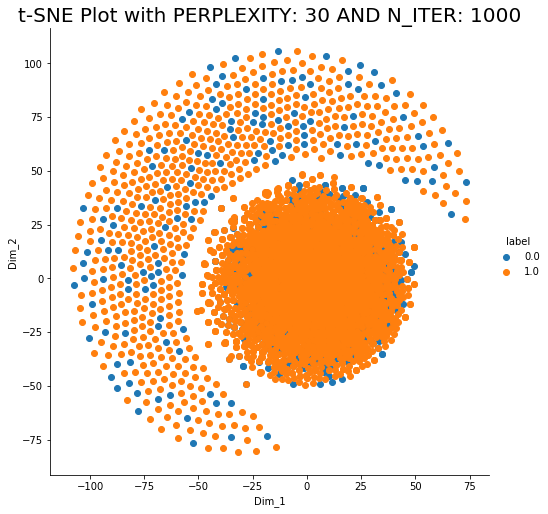

In [32]:
#Making the model with TSNE constructor using:
#default perplexity: 30
#default iteration: 1k

model = TSNE(n_components=2, random_state=0)

#Fitting the model to first 5k standardized data points.

tsne_data = model.fit_transform(standardized_reviews)

# creating a new data frame which helps us in plotting the result data
tsne_data = np.vstack((tsne_data.T, final_score)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", height=7).map(plt.scatter, "Dim_1", "Dim_2").add_legend()
plt.title('t-SNE Plot with PERPLEXITY: 30 AND N_ITER: 1000', size=20)
plt.show()

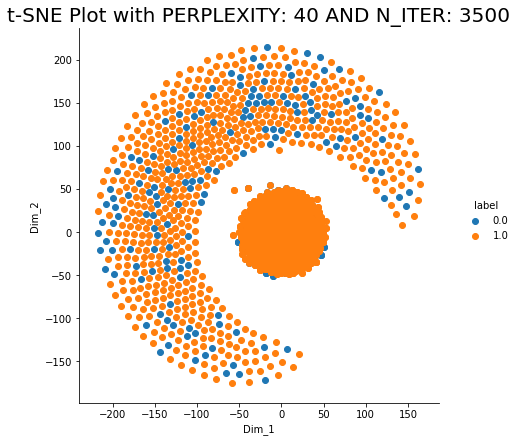

In [33]:
#Making the model with TSNE constructor using:
#perplexity: 40
#iteration: 3.5k

model = TSNE(n_components=2, random_state=0, perplexity=40, n_iter=3500)

#Fitting the model to first 5k standardized data points.

tsne_data = model.fit_transform(standardized_reviews)

# creating a new data frame which helps us in plotting the result data
tsne_data = np.vstack((tsne_data.T, final_score)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", height=6).map(plt.scatter, "Dim_1", "Dim_2").add_legend()
plt.title('t-SNE Plot with PERPLEXITY: 40 AND N_ITER: 3500', size=20)
plt.show()

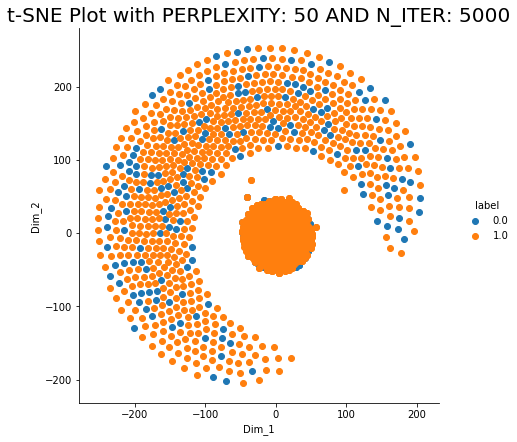

In [34]:
#Making the model with TSNE constructor using:
#perplexity: 50
#iteration: 5k

model = TSNE(n_components=2, random_state=0, perplexity=50, n_iter=5000)

#Fitting the model to first 5k standardized data points.

tsne_data = model.fit_transform(standardized_reviews)

# creating a new data frame which helps us in plotting the result data
tsne_data = np.vstack((tsne_data.T, final_score)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", height=6).map(plt.scatter, "Dim_1", "Dim_2").add_legend()
plt.title('t-SNE Plot with PERPLEXITY: 50 AND N_ITER: 5000', size=20)
plt.show()

## **Observation(s):**
- From the above t-SNE plots we cannot draw a line to separate positive and negative reviews.
- Hence, we cannot classify the polarity of reviews based on t-SNE visualization of BoW encoding.

# TF-IDF

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=10)
text_tfidf = vectorizer.fit_transform(preprocessed_reviews)
print("Shape of matrix after one hot encoding: ",text_tfidf.shape)

Shape of matrix after one hot encoding:  (4986, 2218)


In [31]:
#Using only the first 5k data points

reviews_5k = preprocessed_reviews

tf_idf_vect_reviews = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect_reviews.fit(reviews_5k)
print("Sample Unique Words in corpus: ",tf_idf_vect_reviews.get_feature_names()[0:10])

print('='*50)

final_tf_idf = tf_idf_vect_reviews.transform(reviews_5k)

print("The Type of Count Vectorizer ",type(final_tf_idf))
print("The Shape of Our Text TFIDF Vectorizer: ",final_tf_idf.get_shape())

Sample Unique Words in corpus:  ['ability', 'able', 'able find', 'able get', 'absolute', 'absolutely', 'absolutely delicious', 'absolutely love', 'absolutely no', 'according']
The Type of Count Vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
The Shape of Our Text TFIDF Vectorizer:  (4986, 3144)


# t-SNE on TF-IDF 

In [33]:
#converting sparse matrix to dense matrix python
final_tf_idf = final_tf_idf.todense()

In [34]:
#Importing StandardScalar to perform column-standardization on final_tf_idf.
from sklearn.preprocessing import StandardScaler
standardized_tfidf_reviews = StandardScaler().fit_transform(final_tf_idf)
standardized_tfidf_reviews.shape

(4986, 3144)

In [35]:
#Making the model with TSNE constructor using:
#default perplexity: 30
#default iteration: 1k
from sklearn.manifold import TSNE

final_score = final['Score'].head(5000)

model = TSNE(n_components=2, random_state=0)

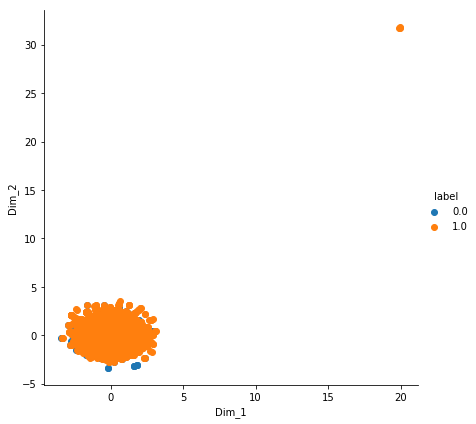

In [36]:
#Fitting the model to first 5k standardized data points.

tsne_data = model.fit_transform(standardized_tfidf_reviews)

# creating a new data frame which helps us in plotting the result data
tsne_data = np.vstack((tsne_data.T, final_score)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", height=6).map(plt.scatter, "Dim_1", "Dim_2").add_legend()
plt.show()

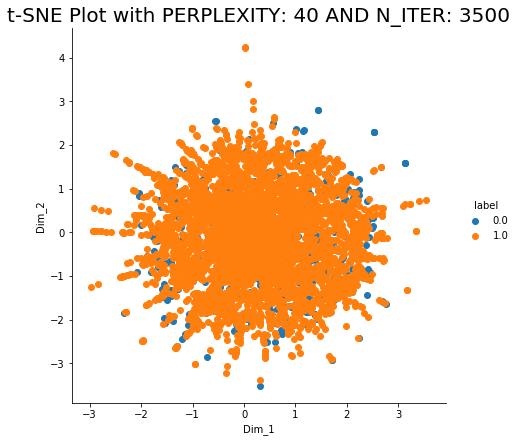

In [37]:
#Fitting the model to first 5k standardized data points.
model = TSNE(n_components=2, random_state=0, perplexity=40, n_iter=3500)

tsne_data = model.fit_transform(standardized_tfidf_reviews)

# creating a new data frame which helps us in plotting the result data
tsne_data = np.vstack((tsne_data.T, final_score)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", height=6).map(plt.scatter, "Dim_1", "Dim_2").add_legend()
plt.title('t-SNE Plot with PERPLEXITY: 40 AND N_ITER: 3500', size=20)
plt.show()

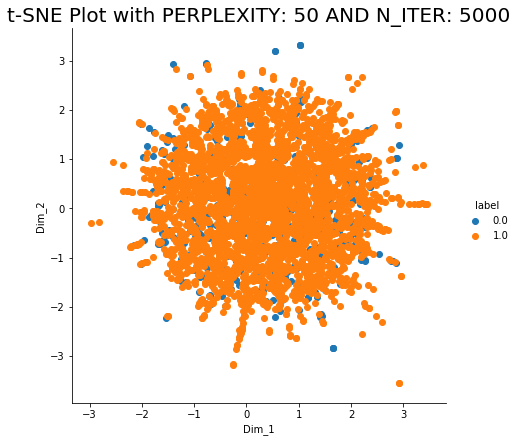

In [38]:
#Fitting the model to first 5k standardized data points.
model = TSNE(n_components=2, random_state=0, perplexity=50, n_iter=5000)

tsne_data = model.fit_transform(standardized_tfidf_reviews)

# creating a new data frame which helps us in plotting the result data
tsne_data = np.vstack((tsne_data.T, final_score)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", height=6).map(plt.scatter, "Dim_1", "Dim_2").add_legend()
plt.title('t-SNE Plot with PERPLEXITY: 50 AND N_ITER: 5000', size=20)
plt.show()

## **Observation(s):**
- From the above t-SNE plots we cannot draw a line to separate positive and negative reviews (Just like in BoW).
- Hence, we cannot classify the polarity of reviews based on t-SNE visualization of TF-IDF encoding.

# AVG-W2V

In [25]:
# Reading glove vectors in python: https://stackoverflow.com/a/38230349/4084039
def loadGloveModel(gloveFile):
    print ("Loading Glove Model")
    f = open(gloveFile,'r', encoding="utf8")
    model = {}
    for line in tqdm(f):
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    print ("Done.", len(model) ," words loaded!")
    return model
model = loadGloveModel('C:/Users/Bhavesh/Desktop/Applied AI/Assignments/Mandatory/2nd Assignment/glove.42B.300d.txt')

Loading Glove Model


1917495it [08:41, 3679.65it/s]


Done. 1917495  words loaded!


In [26]:
words = []

for i in preprocessed_reviews:
    words.extend(i.split(' '))
print("All the words in the corpus", len(words))
words = set(words)
print("The unique words in the corpus", len(words))

inter_words = set(model.keys()).intersection(words)
print("The number of words that are present in both glove vectors and our corpus", \
      len(inter_words),"(",np.round(len(inter_words)/len(words)*100,3),"%)")

words_courpus = {}
words_glove = set(model.keys())
for i in words:
    if i in words_glove:
        words_courpus[i] = model[i]
print("word 2 vec length", len(words_courpus))

All the words in the corpus 185327
The unique words in the corpus 13016
The number of words that are present in both glove vectors and our corpus 12429 ( 95.49 %)
word 2 vec length 12429


In [32]:
#it serializes objects so they can be saved to a file, and loaded in a program again later on.

import pickle

with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [33]:
# average Word2Vec
# compute average word2vec for each review.
avg_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_reviews): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors.append(vector)

print(len(avg_w2v_vectors))
print(len(avg_w2v_vectors[0]))

100%|██████████| 4986/4986 [00:01<00:00, 3918.88it/s]


4986
300


# t-SNE on AVG-W2V

In [37]:
from sklearn.preprocessing import StandardScaler
standardized_data_avgw2v = StandardScaler().fit_transform(avg_w2v_vectors)
print(standardized_data_avgw2v.shape)

(4986, 300)


In [38]:
#Importing TSNE from sklearn.manifold
#Performing TSNE with the top 5k data-points.

from sklearn.manifold import TSNE

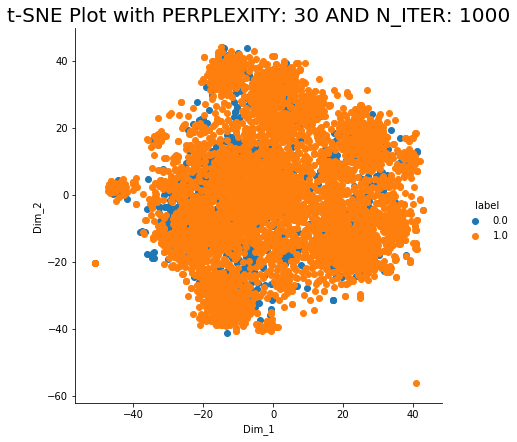

In [40]:
#Making the model with TSNE constructor using:
#default perplexity: 30
#default iteration: 1k

model = TSNE(n_components=2, random_state=0)

#Fitting the model to first 5k standardized data points.

tsne_data = model.fit_transform(standardized_data_avgw2v)

# creating a new data frame which helps us in plotting the result data
tsne_data = np.vstack((tsne_data.T, final['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", height=6).map(plt.scatter, "Dim_1", "Dim_2").add_legend()
plt.title('t-SNE Plot with PERPLEXITY: 30 AND N_ITER: 1000', size=20)
plt.show()

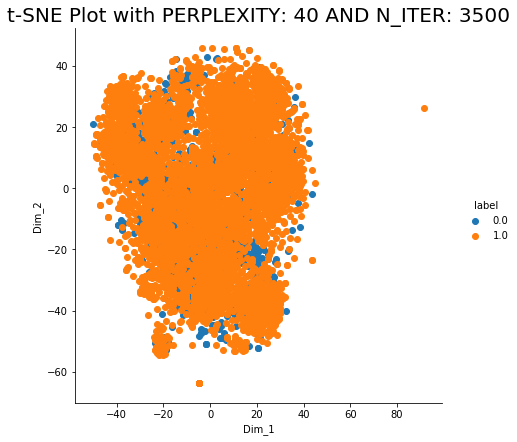

In [41]:
model = TSNE(n_components=2, random_state=0, perplexity=40, n_iter=3500)

#Fitting the model to first 5k standardized data points.

tsne_data = model.fit_transform(standardized_data_avgw2v)

# creating a new data frame which helps us in plotting the result data
tsne_data = np.vstack((tsne_data.T, final['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", height=6).map(plt.scatter, "Dim_1", "Dim_2").add_legend()
plt.title('t-SNE Plot with PERPLEXITY: 40 AND N_ITER: 3500', size=20)
plt.show()

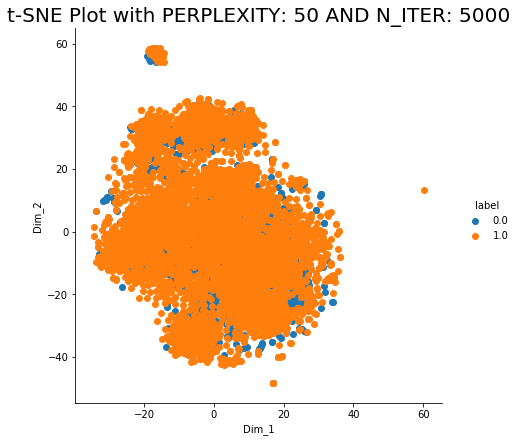

In [42]:
model = TSNE(n_components=2, random_state=0, perplexity=50, n_iter=5000)

#Fitting the model to first 5k standardized data points.

tsne_data = model.fit_transform(standardized_data_avgw2v)

# creating a new data frame which helps us in plotting the result data
tsne_data = np.vstack((tsne_data.T, final['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", height=6).map(plt.scatter, "Dim_1", "Dim_2").add_legend()
plt.title('t-SNE Plot with PERPLEXITY: 50 AND N_ITER: 5000', size=20)
plt.show()

## **Observation(s):**
- From the above t-SNE plots we cannot draw a line to separate positive and negative reviews (Just like in BoW, TD-IDF).
- Hence, we cannot classify the polarity of reviews based on t-SNE visualization of Avg W2V encoding.

# IF-IDF Weighted AVG-W2V

In [44]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_model = TfidfVectorizer()
tfidf_model.fit(preprocessed_reviews)

# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [45]:
# average Word2Vec
# compute average word2vec for each review.
tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_reviews): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence: # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vector = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors.append(vector)

print(len(tfidf_w2v_vectors))
print(len(tfidf_w2v_vectors[0]))

100%|██████████| 4986/4986 [00:00<00:00, 13885.04it/s]


4986
300


# t-SNE with IF-IDF Weighted W2V

In [46]:
from sklearn.preprocessing import StandardScaler
std_data_tfidf_w2v = StandardScaler().fit_transform(tfidf_w2v_vectors)
print(std_data_tfidf_w2v.shape)

(4986, 300)


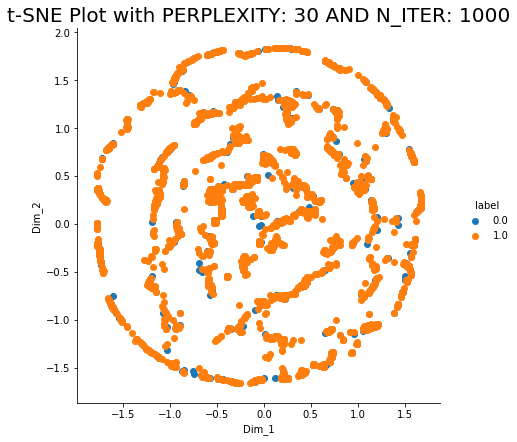

In [47]:
from sklearn.manifold import TSNE

model = TSNE(n_components=2, random_state=0)
#Fitting the model to first 5k standardized data points.

tsne_data = model.fit_transform(std_data_tfidf_w2v)

# creating a new data frame which helps us in plotting the result data
tsne_data = np.vstack((tsne_data.T, final['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", height=6).map(plt.scatter, "Dim_1", "Dim_2").add_legend()
plt.title('t-SNE Plot with PERPLEXITY: 30 AND N_ITER: 1000', size=20)
plt.show()

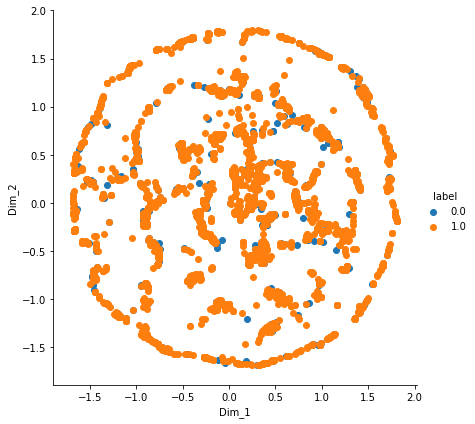

In [48]:
model = TSNE(n_components=2, random_state=0, perplexity=40, n_iter=3500)

#Fitting the model to first 5k standardized data points.

tsne_data = model.fit_transform(std_data_tfidf_w2v)

# creating a new data frame which helps us in plotting the result data
tsne_data = np.vstack((tsne_data.T, final['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", height=6).map(plt.scatter, "Dim_1", "Dim_2").add_legend()
plt.show()

# Obervation(s):
- Almost every t-SNE plot contains points which are heavily overlapping.
- Hence because of this it is difficult to come to a conclusion as the dataset is imbalanced. Even if we take points more than 5k, points of one class(Positive) dominates the other quite heavily.
- Plot of TF-IDF W2V has more scattered data points than other t-SNE plots. Though it is inconclusive.
- It will be difficult to draw a line to classify the polarity of reviews.